In [ ]:
# 30 May 2022

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
#import gym
import random
import math

from gym import Env, spaces
import time


In [2]:
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

# Dictionary containing some colors
colors = {'blue': (255, 0, 0), 'green': (0, 255, 0), 'red': (0, 0, 255),
        'yellow': (0, 255, 255), 'magenta': (255, 0, 255), 'cyan': (255, 255, 0),
        'white': (255, 255, 255), 'black': (0, 0, 0), 'gray': (125, 125, 125), 'rand':
        np.random.randint(0, high=256, size=(3,)).tolist(), 'dark_gray': (50, 50, 50),
        'light_gray': (220, 220, 220)
        }

In [3]:

class OceanScape(Env):
    def __init__(self):
        super(OceanScape, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = np.array((300, 600, 3)) #height x width, aka rows x cols
        self.canvas_size = self.observation_shape[:2]
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)

        # Define an action space ranging from 0 to 4
        #{0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
        self.action_space = spaces.Discrete(5,)

        # Create a canvas to render the environment images upon
        self.canvas = np.ones(self.observation_shape) * 1

        # Define elements present inside the environment
        self.elements = []

        # Maximum battery can take at once
        self.max_battery = 1000

        # Permissible area of buoy to be
        self.y_min = int(self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]

        # Canvas size is defined in y, x
        # Goal is defined in x, y
        # TODO: Define in 3 dim
        self.goal = (-np.inf, -np.inf)
        print('goal: ', self.goal)
        self.goal_radius = 50
        
        # TODO: create wind region
        # Split screen into 200x200 squares (12 for 600x800 screen)
        # Assume time invariant
        # Vector at each grid: x and y components
        # TODO: add additional dimensions (may be different winds

        self.grid_width = 50 # pixels
        self.wind_grid_shape = np.ceil(self.canvas_size/self.grid_width).astype(int)
        print(f'{self.canvas_size=}', f'{self.grid_width=}', f'{self.wind_grid_shape=}')

        # Wind is a x,y vector
        self.wind_x_grid = np.zeros(self.wind_grid_shape) 
        self.wind_y_grid = np.zeros(self.wind_grid_shape) 

        # Max of how much wind should drain the battery at each step
        self.wind_cost_multiplier = 1

        # Where to save quiver plot of wind
        self.wind_image_filename = "generated_wind_plot.png"

    def plotWindImg(self):
        # matplotlib figsize is in inches, convert to px
        my_dpi=100
        plt.figure(figsize=(self.canvas_size[0]/my_dpi, 
                            self.canvas_size[1]/my_dpi), dpi=my_dpi)
        plt.axis("off")
        plt.quiver(self.wind_x_grid, self.wind_y_grid, color='g')
        plt.savefig(self.wind_image_filename, transparent=True)

    def getWindStrength(self):
        x_pos, y_pos = self.buoy.get_position()
        column = np.floor(x_pos/self.grid_width).astype(int)
        row = np.floor(y_pos/self.grid_width).astype(int)

        # NOTE: two dimensions, x and y componets of wind vector, at each
        # square
        try:
            x_strength = self.wind_x_grid[row][column]
            y_strength = self.wind_y_grid[row][column]
            return x_strength, y_strength
        except:
            print(f'failed! {x_pos}, {y_pos}, {column}, {row}')
            print(f'vs shape of {self.wind_x_grid}, {self.wind_x_grid.shape}')
            print(f'vs shape of {self.wind_y_grid}, {self.wind_y_grid.shape}')

        # 51 x 31

# reset to initial state: Fixed start and goal locations, Semi random wind
# field

    def reset(self):
        # Reset the fuel consumed
        self.batt_left = self.max_battery

        # Reset the reward
        self.ep_return = 0 

        # Determine a place to intialise the chopper in
        x = random.randrange(int(self.observation_shape[1] * 0.05), int(self.observation_shape[1] * 0.10))
        y = random.randrange(int(self.observation_shape[0] * 0.15), int(self.observation_shape[0] * 0.20))

        # Intialise the chopper
        self.buoy = Buoy("buoy", self.x_max, self.x_min, self.y_max, self.y_min)
        self.buoy.set_position(x,y)

        self.elements = [self.buoy]

        # initialize goal
        self.goal = (int(np.random.rand() * self.canvas_size[1]), 
                    int(np.random.rand() * self.canvas_size[0]))

        # Initialize wind region 
        self.wind_x_grid = np.random.random_sample(self.wind_grid_shape) 
        self.wind_y_grid = np.random.random_sample(self.wind_grid_shape) 

        # Generate wind region plot
        self.plotWindImg()

        # Reset the Canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas() # TODO: why this no work?

        # return the observation
        return self.canvas 

# Step: movement is omni, but fuel budget is reduced based on direction
    def inGoalRegion(self):
        #print(f'position {self.buoy.get_position()}, goal {self.goal}')
        #dist = np.linalg.norm(self.buoy.get_position() - self.goal) 
        b_x, b_y = self.buoy.get_position()
        
        dist = np.sqrt( (self.goal[0] - b_x)**2 + (self.goal[1] - b_y)**2)
        if dist <= self.goal_radius:
            #print('distance', dist)
            print(f'hurray! in goal region {self.goal},'
                  f' posit {b_x}, {b_y}, dist {dist}')
            
            return True
        return False


    def step(self, action):
        #print(action)
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter
        self.batt_left -= 1

        # NO Reward for executing a step. Sparse rewards.
        # reward = 1

        # apply the action to the chopper
        move_amt = 32 
        if action == 0:
            self.buoy.move(0,move_amt)
            move_x, move_y = 0, 1
        elif action == 1:
            self.buoy.move(0,-move_amt)
            move_x, move_y = 0, -1
        elif action == 2:
            self.buoy.move(move_amt,0)
            move_x, move_y = 1, 0
        elif action == 3:
            self.buoy.move(-move_amt,0)
            move_x, move_y = -1, 0
        elif action == 4:
            self.buoy.move(0,0)
            move_x, move_y = 0, 0

        # Additional decrease from fighting wind
        wind_x, wind_y = self.getWindStrength()
        self.batt_left -= math.hypot(move_x - wind_x, move_y - wind_y)

        if self.inGoalRegion(): 
            # giant pot for reaching end goal as a function of batt left
            self.ep_return += 0.1 * (self.max_battery - self.batt_left)
            print(f'reached goal, final return {self.ep_return}')
            
            done = True
        # else:
            #TODO: change this! Some heuristic I guess... Right now sparse
            # Reward is zero on all transitions, except those into the goal state, on which it is +1. After reaching the goal state (G), the agent returns to the start state (S) to begin a new episode.
        # If out of fuel, end the episode.
        if self.batt_left <= 0:
            self.ep_return = -10
            
            print(f'oops ran out of battery, final return {self.ep_return}')
            print(f'final position {self.buoy.get_position()}')
            done = True

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        reward = self.ep_return

        return self.canvas, reward, done, []


# Render: renders wind field, current location, and visited locations, as
# well as start and goal locations
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas


    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}


    def close(self):
        cv2.waitKey(2500)
        cv2.destroyAllWindows()


    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # NOTE: circle method is in x,y
        self.canvas = cv2.circle(self.canvas, self.goal, radius=self.goal_radius-32, 
                                 color=(0, 128, 0), thickness=-1) 

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            # WARNING: Note, since this is matrix notation, put y coord
            # (rows) first 
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
            
            breadcrumbs = elem.get_history()[:-1]

            for crumb in breadcrumbs:
                p_x, p_y = crumb
                # Use less efficient method for now (circle per)
                # NOTE: circle method is in x,y
                self.canvas = cv2.circle(self.canvas, (p_x+32, p_y+32), radius=2,
                                         color=(0, 0, 255), thickness=-1) 

        # TODO: Draw wind region 

        #text = 'Batt Left: {} | Rewards: {}'.format(batt_left, self.ep_return)
        text = f'Batt Left: {self.batt_left:0.0f} | Rewards: {self.ep_return:.2f} ' \
        f'| Goal: {self.goal} Radius {self.goal_radius}| Loc: {x, y}'

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  0.6, (0,0,0), 1, cv2.LINE_AA)

        self.drawWindBoundaries()
        self.drawWindArrows()

        # NOTE: circle method is in x,y
        #canvas = cv2.circle(self.canvas, (0,0), radius=10, 
        #                         color=(0, 128, 0), thickness=-1) 

        #cv2.arrowedLine(self.canvas, (0, 0), (200, 0), colors['blue'], 3, 8, 0, 0.1)

        #text = 'x = 0 cv2'
        #canvas = cv2.putText(canvas, text, (0,10) , font,  0.6,
                             # colors['blue'], 1, cv2.LINE_AA)

    def drawWindArrows(self):
        offset = np.ceil(0.2 * self.grid_width).astype(int)

        #xs = np.arange(0, self.canvas_size[0], self.grid_width)
        #ys = np.arange(0, self.canvas_size[1], self.grid_width)

        for index, x in np.ndenumerate(self.wind_x_grid):
            j, k = index
            dx = self.wind_x_grid[j][k] * int(self.grid_width / 2)
            dx = np.ceil(dx).astype(int)

            dy = self.wind_y_grid[j][k] * int(self.grid_width/2)
            dy = np.ceil(dy).astype(int)

            start_x = j * self.grid_width + offset
            start_y = k * self.grid_width + offset
            
            #print(dx, dy, start_x, start_y)
            line_thickness=1
            tip_length=0.2 
            cv2.arrowedLine(self.canvas, 
                            (start_y, start_x), 
                            (start_y + dy, start_x + dx),
                            colors['black'], line_thickness, 8, 0, tip_length)
            

# colors, 3, 8, 0, 0.5

    def drawWindBoundaries(self):

        height, width = self.canvas_size

        # Draw vertical lines at each x grid point
        for x in range(self.wind_grid_shape[1]): 
            x_pos = x * self.grid_width
            cv2.line(self.canvas, pt1=(x_pos, 0), pt2=(x_pos, height),
                     color=colors['red'], thickness=1)

        # Draw horizontal lines at each y grid point
        for y in range(self.wind_grid_shape[0]): 
            y_pos = y * self.grid_width
            cv2.line(self.canvas, pt1=(0, y_pos), pt2=(width, y_pos),
                     color=colors['blue'], thickness=1)

class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name

        self.history = []
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

        self.history.append((self.x, self.y))

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

    def get_history(self):
        return self.history 


In [4]:

class Buoy(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Buoy, self).__init__(name, x_max, x_min, y_max, y_min)
        cv2.imread('./argo_buoy.py')
        self.icon = cv2.imread("argo_buoy.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))


/home/nrw/v3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


goal:  (-inf, -inf)
self.canvas_size=array([300, 600]) self.grid_width=50 self.wind_grid_shape=array([ 6, 12])
oops ran out of battery, final return -10
final position (160, 174)


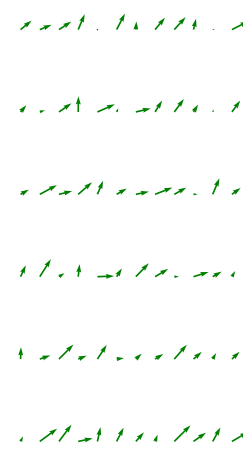

In [5]:


env = OceanScape()
obs = env.reset()
#plt.imshow(obs)
#plt.show()

#screen = env.render(mode = "rgb_array")
#plt.imshow(screen)
#plt.show()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()
    #plt.show()

    if done == True:
        cv2.waitKey(0)
        break

env.close()

# TODO: add wind affect on batt
#       + create wind region, reset wind region, 
#       + add effect on battery, and 
# TODO: plot wind region